In [7]:
import pandas as pd
import numpy as np
from sklearn import preprocessing

def fullRead(pathToTable, sep, anthro = False):

  df_renamed = pd.read_csv(pathToTable, sep = sep, encoding = "latin_1")


  # reading and merging    
  
  if anthro == True:
    df_anthro = pd.read_csv("data/chronicAnthropometricCardiovascularData.csv", sep=";", decimal=",")
    df_renamed = df_renamed.merge(df_anthro)

    # separating by time moment and renaming

    df_renamed["Weight"] = ""
    df_renamed["BMI"] = ""
    df_renamed["Fat"] = ""
    df_renamed["CVRI"] = ""
    df_renamed["Bpmin"] = ""
    df_renamed["Bpmax"] = ""
    df_renamed["Frec"] = ""

    for i in range(len(df_renamed)):

        if df_renamed.loc[i]["Time"] == "Initial":
            df_renamed.loc[i,"Weight"] = df_renamed.loc[i]["Peso inicial"]
            df_renamed.loc[i,"BMI"] = df_renamed.loc[i]["IMC Inicial"]
            df_renamed.loc[i,"Fat"] = df_renamed.loc[i]["Grasa inicial"]
            df_renamed.loc[i,"CVRI"] = df_renamed.loc[i]["IRCV inicial"] 
            df_renamed.loc[i,"Bpmin"] = df_renamed.loc[i]["Bpmin inicial"] 
            df_renamed.loc[i,"Bpmax"] = df_renamed.loc[i]["Bpmax inicial"] 
            df_renamed.loc[i,"Frec"] = df_renamed.loc[i]["Frec inicial"] 
                
        if df_renamed.loc[i]["Time"] == "Final":
        
            df_renamed.loc[i,"Weight"] = df_renamed.loc[i]["Peso final"]
            df_renamed.loc[i,"BMI"] = df_renamed.loc[i]["IMC Final"]
            df_renamed.loc[i,"Fat"] = df_renamed.loc[i]["Grasa final"]
            df_renamed.loc[i,"CVRI"] = df_renamed.loc[i]["IRCV Final"] 
            df_renamed.loc[i,"Bpmin"] = df_renamed.loc[i]["Bpmin final"] 
            df_renamed.loc[i,"Bpmax"] = df_renamed.loc[i]["Bpmax final"] 
            df_renamed.loc[i,"Frec"] = df_renamed.loc[i]["Frec final"] 
        
    df_renamed.drop(columns = ["Peso inicial", "Peso final", "Delta Peso", "Talla", "IMC Inicial", "IMC Final", "Delta IMC", "Grasa inicial", "Grasa final", "Delta Grasa", "IRCV Final", "IRCV inicial", "Bpmin final", "Bpmin inicial", "Bpmax final", "Bpmax inicial", "Frec final", "Frec inicial",], inplace=True )
  
  df_renamed.drop(columns = ["Unnamed: 0", "grouping"], inplace=True )
  df_renamed.fillna(0, inplace=True)
  return df_renamed

def scaling(df_read):
   
   scaler = preprocessing.MinMaxScaler()
   numCols = df_read.select_dtypes(include=np.number).drop("numVol",1).columns
   df_read[numCols] = scaler.fit_transform(df_read[numCols])
   return df_read

df = scaling(fullRead("data/urineAnt_ord.csv", sep = ",", anthro=True))

C:\Users\dres2\AppData\Local\Temp\ipykernel_10296\4204426569.py:56: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  numCols = df_read.select_dtypes(include=np.number).drop("numVol",1).columns


In [8]:
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
 
enc = OrdinalEncoder()
enc.fit(df[["Sweetener", "Sex", "Time"]])
df[["Sweetener", "Sex", "Time"]] = enc.transform(df[["Sweetener", "Sex",  "Time"]])

# Initial = 1, Final = 0

X, y = df[df["Time"] == 1].drop(["numVol", "Time"], axis=1), df[df["Time"] == 0].drop(['Time','numVol', 'Sweetener', 'Time', 'Sex', 'Weight','BMI', 'Fat', 'CVRI', 'Bpmin', 'Bpmax', 'Frec'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_full, y_full = df[df["Time"] == 1].drop(["numVol", "Time"], axis=1), df[df["Time"] == 0].drop(['Time','numVol', 'Sweetener', 'Time'], axis = 1)
X_fulltrain, X_fulltest, y_fulltrain, y_fulltest = train_test_split(X_full, y_full, test_size=0.3, random_state=42)

#X_test.to_csv("X_met_test_urineAnt.csv", index=False)
#X_fulltest.to_csv("X_full_test_urineAnt.csv",index=False)

In [9]:
df1Num = df[df.select_dtypes(include=np.number).drop("numVol",1).columns]

from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold(0.005)
selector.fit(df1Num)
df1Num.columns[selector.get_support()]

C:\Users\dres2\AppData\Local\Temp\ipykernel_10296\3624912679.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df1Num = df[df.select_dtypes(include=np.number).drop("numVol",1).columns]


Index(['CA', 'CA.G', 'CA.S', 'CA.GS', 'Total.CA', 'DHPAA', 'DHPAA.G',
       'DHPAA.GG', 'DHPAA.GS', 'DHPAA.SS', 'Total.DHPAA', 'TFA.S',
       'TFA.di.sulfate.1', 'Total.TFA', 'VA', 'VA.GG', 'VA.GS', 'VA.SS',
       'Total.VA', 'Sweetener', 'Time', 'Sex', 'Weight', 'BMI', 'Fat', 'CVRI',
       'Bpmin', 'Bpmax', 'Frec'],
      dtype='object')

In [14]:
# 2. Univariate Feature Selection with SelectKBest

#Divide the features into Independent and Dependent Variable
X = df1Num.drop('CA' , axis =1)
y = df1Num['CA']

from sklearn.feature_selection import SelectKBest, mutual_info_regression

selector = SelectKBest(mutual_info_regression, k =5)
selector.fit(X, y)
X.columns[selector.get_support()]

Index(['CA.G', 'CA.S', 'CA.GS', 'TFA.di.sulfate.1', 'VA.GG'], dtype='object')

In [4]:
# 3. RFE Selector

X = df1.drop(['Sex', "Sweetener", "numVol", "Time"] , axis =1)
y = df1['Sex']

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
# #Selecting the Best important features according to Logistic Regression
rfe_selector = RFE(estimator=LogisticRegression(),n_features_to_select = 2, step = 1)
rfe_selector.fit(X, y)
X.columns[rfe_selector.get_support()]

Index(['Weight', 'Fat'], dtype='object')

In [5]:
from sklearn.feature_selection import SelectFromModel

X = df1.drop(['Sex', "Sweetener", "numVol", "Time"] , axis =1)
y = df1['Sex']
# #Selecting the Best important features according to Logistic Regression using SelectFromModel
sfm_selector = SelectFromModel(estimator=LogisticRegression())
sfm_selector.fit(X, y)
X.columns[sfm_selector.get_support()]

Index(['CA.GS', 'DHPAA', 'DHPAA.G', 'DHPAA.GG', 'TFA.G', 'TFA.S',
       'TFA.di.sulfate.1', 'Total.TFA', 'VA.GS'],
      dtype='object')

In [6]:
from sklearn.feature_selection import SequentialFeatureSelector
#Selecting the Best important features according to Logistic Regression
sfs_selector = SequentialFeatureSelector(estimator=LogisticRegression(), n_features_to_select = 3, cv =10, direction ='backward')
sfs_selector.fit(X, y)
X.columns[sfs_selector.get_support()]

Index(['CA.GS', 'TFA.di.sulfate.1', 'VA.GS'], dtype='object')

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

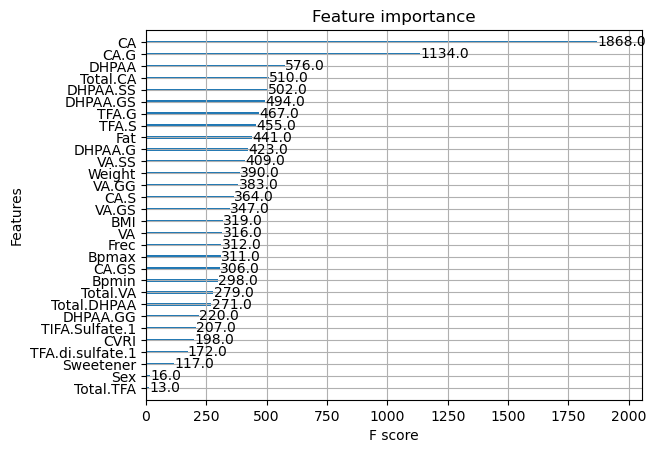

In [23]:
from xgboost import XGBRegressor, plot_importance

model = XGBRegressor()
model.fit(X_train, y_train)

plot_importance(model)